In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold

In [2]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [3]:
SIGNAL_CATEGORIES = {
    'ECG': ['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'PPG': ['PPG_HR_mean','PPG_HR_std','PPG_RMSSD','PPG_SDNN','PPG_LF','PPG_HF','PPG_LF_HF','PPG_num_beats','PPG_RiseTime','PPG_DecayTime','PPG_PAV_mean','PPG_PAV_std','PPG_RI'],
    'EDA': ['EDA_mean','EDA_std','EDA_min','EDA_max','EDA_range','EDA_slope','scl_mean','scl_std','scr_mean','scr_std','corr_scl_t','scr_count','scr_amp','scr_sum','scr_area'],
    'RESP': ['Resp_mean','Resp_std','Resp_I_mean','Resp_I_std','Resp_E_mean','Resp_E_std','Resp_IE_ratio','Resp_range','Resp_insp_vol','Resp_rate','Resp_duration'],
}
random = 13577

# Modelos que requieren normalización
MODELS_NEED_SCALING = ["KNN", "LDA"]

In [4]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [5]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [6]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics


In [7]:
def train_and_evaluate_group(X, y, groups, model, param_grid, model_name, signal_name):
    group_kfold = GroupKFold(n_splits=5)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=group_kfold,
        n_jobs=16,
        verbose=1
    )
    grid_search.fit(X, y, groups=groups)  # Aquí pasamos los grupos (sujetos)

    best_model = grid_search.best_estimator_

    y_true, y_pred = [], []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_model.fit(X_train, y_train)
        preds = best_model.predict(X_test)

        y_true.extend(y_test)
        y_pred.extend(preds)

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [8]:
def train_and_evaluate_loso(X, y, subjects, base_model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()
    y_true_all = []
    y_pred_all = []

    all_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    for train_idx, test_idx in logo.split(X, y, groups=subjects):
        y_train_fold = y[train_idx]
        class_counts = Counter(y_train_fold)
        print(f"Distribución de clases en el fold: {class_counts}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_subjects = subjects.iloc[train_idx]

        # Construir pipeline con StandardScaler y modelo
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('clf', base_model)
        ])

        # Ajustar nombres del grid search para el pipeline
        adjusted_param_grid = {f"clf__{k}": v for k, v in param_grid.items()}

        # Validación cruzada interna con LOGO
        inner_logo = LeaveOneGroupOut()
        inner_cv = inner_logo.split(X_train, y_train, groups=train_subjects)

        grid_search = GridSearchCV(pipeline, adjusted_param_grid, cv=inner_cv, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name} (LOSO Fold)")
        best_params = grid_search.best_params_
        print(f"Best params for {model_name} in {signal_name}: {best_params}")

        all_metrics["accuracy"].append(metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0])
        all_metrics["precision"].append(metrics.loc[metrics["Métrica"] == "Precision", "Valor"].values[0])
        all_metrics["recall"].append(metrics.loc[metrics["Métrica"] == "Recall", "Valor"].values[0])
        all_metrics["f1_score"].append(metrics.loc[metrics["Métrica"] == "F1 Score", "Valor"].values[0])

        plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    final_metrics = {
        "accuracy": np.mean(all_metrics["accuracy"]),
        "precision": np.mean(all_metrics["precision"]),
        "recall": np.mean(all_metrics["recall"]),
        "f1_score": np.mean(all_metrics["f1_score"])
    }

    print(f'[{signal_name} - {model_name}] Final Metrics:')
    print(pd.DataFrame(final_metrics, index=["Valor"]).T)

    folds = range(1, len(all_metrics["accuracy"]) + 1)
    plt.figure(figsize=(10, 6))

    plt.plot(folds, all_metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(folds, all_metrics["precision"], label="Precision", marker='x')
    plt.plot(folds, all_metrics["recall"], label="Recall", marker='s')
    plt.plot(folds, all_metrics["f1_score"], label="F1 Score", marker='^')

    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title(f"Metrics per Fold - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return final_metrics

In [9]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random),
        {"max_depth": [3, 5, 10, 15],
         "min_samples_split": [2, 5, 10], 
         "max_leaf_nodes": [10, 15, 20, 30, 40],
         "criterion": ["gini", "entropy"]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced', random_state=random),
        {"n_estimators": [100, 200, 300],
         "max_depth": [3, 5, 10, 20],
         "min_samples_split": [2, 5, 10, 20],
         "min_samples_leaf": [2, 4],
         "max_features": ['sqrt', 'log2']}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {"n_estimators": [50, 100, 200, 300], 
         "learning_rate": [0.01, 0.1, 0.5, 1], 
         "estimator": [
             DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
             DecisionTreeClassifier(max_depth=3, class_weight='balanced')
         ]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}

results = {}

In [10]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [11]:
df.columns

Index(['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF',
       'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm', 'PPG_HR_mean',
       'PPG_HR_std', 'PPG_RMSSD', 'PPG_SDNN', 'PPG_LF', 'PPG_HF', 'PPG_LF_HF',
       'PPG_num_beats', 'PPG_RiseTime', 'PPG_DecayTime', 'PPG_PAV_mean',
       'PPG_PAV_std', 'PPG_RI', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
       'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std',
       'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area',
       'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean',
       'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol',
       'Resp_rate', 'Resp_duration', 'subject', 'label'],
      dtype='object')

In [12]:
print("Valores nulos por columna:\n", df.isna().sum())

Valores nulos por columna:
 HR_mean          0
HR_std           0
NN50             0
pNN50            0
TINN             0
rmsHRV           0
LF               0
HF               0
LF_HF            0
sum_f            0
rel_f            0
LF_norm          0
HF_norm          0
PPG_HR_mean      0
PPG_HR_std       0
PPG_RMSSD        0
PPG_SDNN         0
PPG_LF           0
PPG_HF           0
PPG_LF_HF        0
PPG_num_beats    0
PPG_RiseTime     0
PPG_DecayTime    0
PPG_PAV_mean     0
PPG_PAV_std      0
PPG_RI           0
EDA_mean         0
EDA_std          0
EDA_min          0
EDA_max          0
EDA_range        0
EDA_slope        0
scl_mean         0
scl_std          0
scr_mean         0
scr_std          0
corr_scl_t       0
scr_count        0
scr_amp          0
scr_sum          0
scr_area         0
Resp_mean        0
Resp_std         0
Resp_I_mean      0
Resp_I_std       0
Resp_E_mean      0
Resp_E_std       0
Resp_IE_ratio    0
Resp_range       0
Resp_insp_vol    0
Resp_rate        0
Res

In [13]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 21943
Label: 2 total: 8973
Label: 3 total: 21939
Label: 4 total: 13869


In [14]:
#Aplicar muestra binaria
df['label'] = df['label'].apply(lambda x: 1 if x in [1, 2] else 2)

In [15]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 30916
Label: 2 total: 35808


Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.900862  ALL - DecisionTree
1  Precision  0.901059  ALL - DecisionTree
2     Recall  0.900862  ALL - DecisionTree
3   F1 Score  0.900910  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.9009
ALL - DecisionTree - Confusion Matrix
[[5571  612]
 [ 711 6451]]


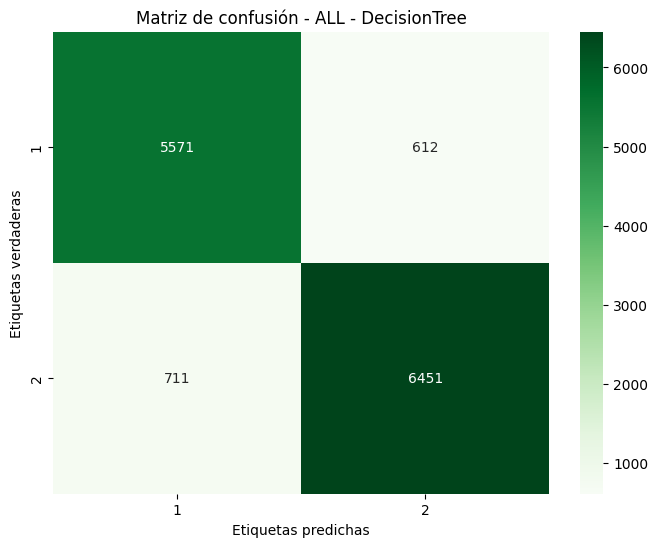

Training with ALL signals:  20%|██        | 1/5 [02:27<09:48, 147.02s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      6183
           2       0.91      0.90      0.91      7162

    accuracy                           0.90     13345
   macro avg       0.90      0.90      0.90     13345
weighted avg       0.90      0.90      0.90     13345

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ALL - RandomForest Metrics
     Métrica    Valor               Etapa
0   Accuracy  0.99985  ALL - RandomForest
1  Precision  0.99985  ALL - RandomForest
2     Recall  0.99985  ALL - RandomForest
3   F1 Score  0.99985  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9999
ALL - RandomForest - Confusion Matrix
[[6182    1]
 [   1 7161]]


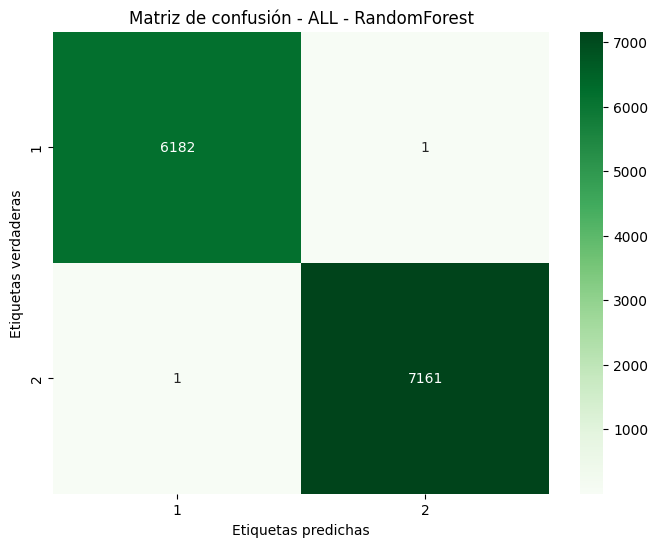

Training with ALL signals:  40%|████      | 2/5 [1:27:18<2:32:47, 3055.71s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.999625  ALL - AdaBoost
1  Precision  0.999625  ALL - AdaBoost
2     Recall  0.999625  ALL - AdaBoost
3   F1 Score  0.999625  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.9996
ALL - AdaBoost - Confusion Matrix
[[6180    3]
 [   2 7160]]


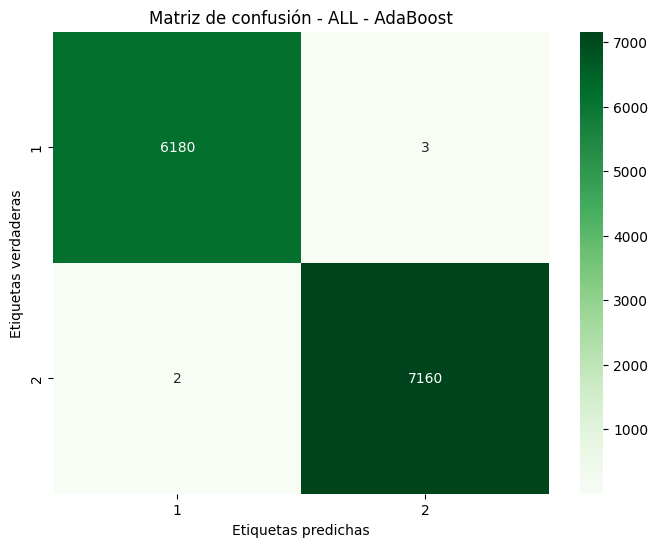

Training with ALL signals:  60%|██████    | 3/5 [2:16:48<1:40:33, 3016.53s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.822630  ALL - LDA
1  Precision  0.824046  ALL - LDA
2     Recall  0.822630  ALL - LDA
3   F1 Score  0.821693  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.8226
ALL - LDA - Confusion Matrix
[[4704 1479]
 [ 888 6274]]


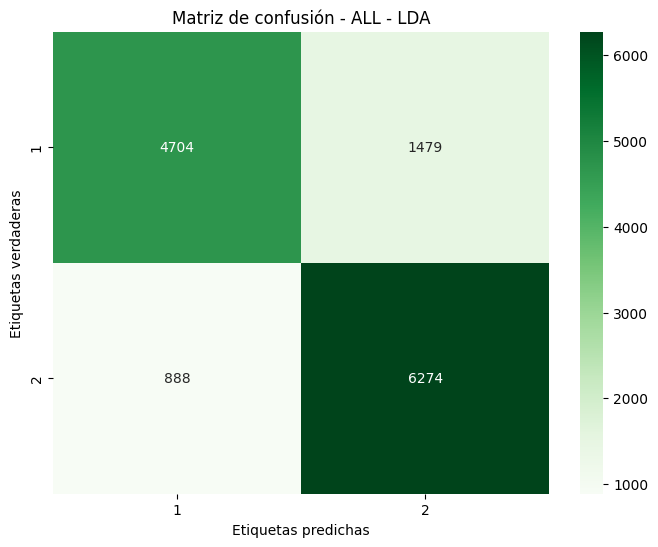

Training with ALL signals:  80%|████████  | 4/5 [2:17:00<30:30, 1830.33s/it]  

              precision    recall  f1-score   support

           1       0.84      0.76      0.80      6183
           2       0.81      0.88      0.84      7162

    accuracy                           0.82     13345
   macro avg       0.83      0.82      0.82     13345
weighted avg       0.82      0.82      0.82     13345

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.735481  ALL - KNN
1  Precision  0.735458  ALL - KNN
2     Recall  0.735481  ALL - KNN
3   F1 Score  0.735470  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.7355
ALL - KNN - Confusion Matrix
[[4414 1769]
 [1761 5401]]


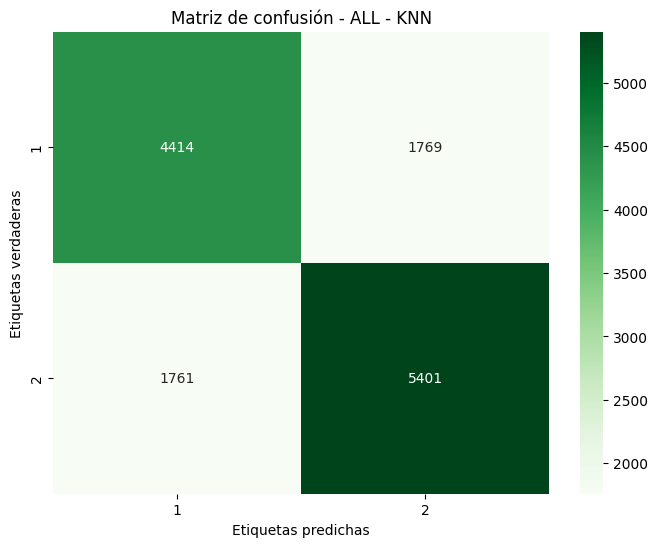

Training with ALL signals: 100%|██████████| 5/5 [2:17:12<00:00, 1646.56s/it]

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.74     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.74      0.74      0.74     13345


Final Comparison:
ALL - DecisionTree:
     Métrica     Valor               Etapa
0   Accuracy  0.900862  ALL - DecisionTree
1  Precision  0.901059  ALL - DecisionTree
2     Recall  0.900862  ALL - DecisionTree
3   F1 Score  0.900910  ALL - DecisionTree
ALL - RandomForest:
     Métrica    Valor               Etapa
0   Accuracy  0.99985  ALL - RandomForest
1  Precision  0.99985  ALL - RandomForest
2     Recall  0.99985  ALL - RandomForest
3   F1 Score  0.99985  ALL - RandomForest
ALL - AdaBoost:
     Métrica     Valor           Etapa
0   Accuracy  0.999625  ALL - AdaBoost
1  Precision  0.999625  ALL - AdaBoost
2     Recall  0.999625  ALL - AdaBoost
3   F1 Score  0.9

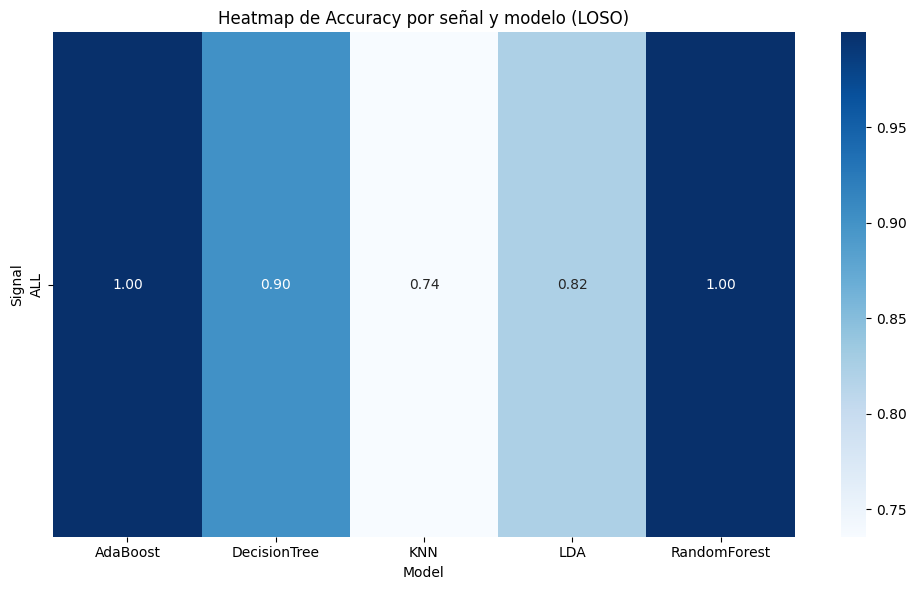

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_15152\2378078127.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

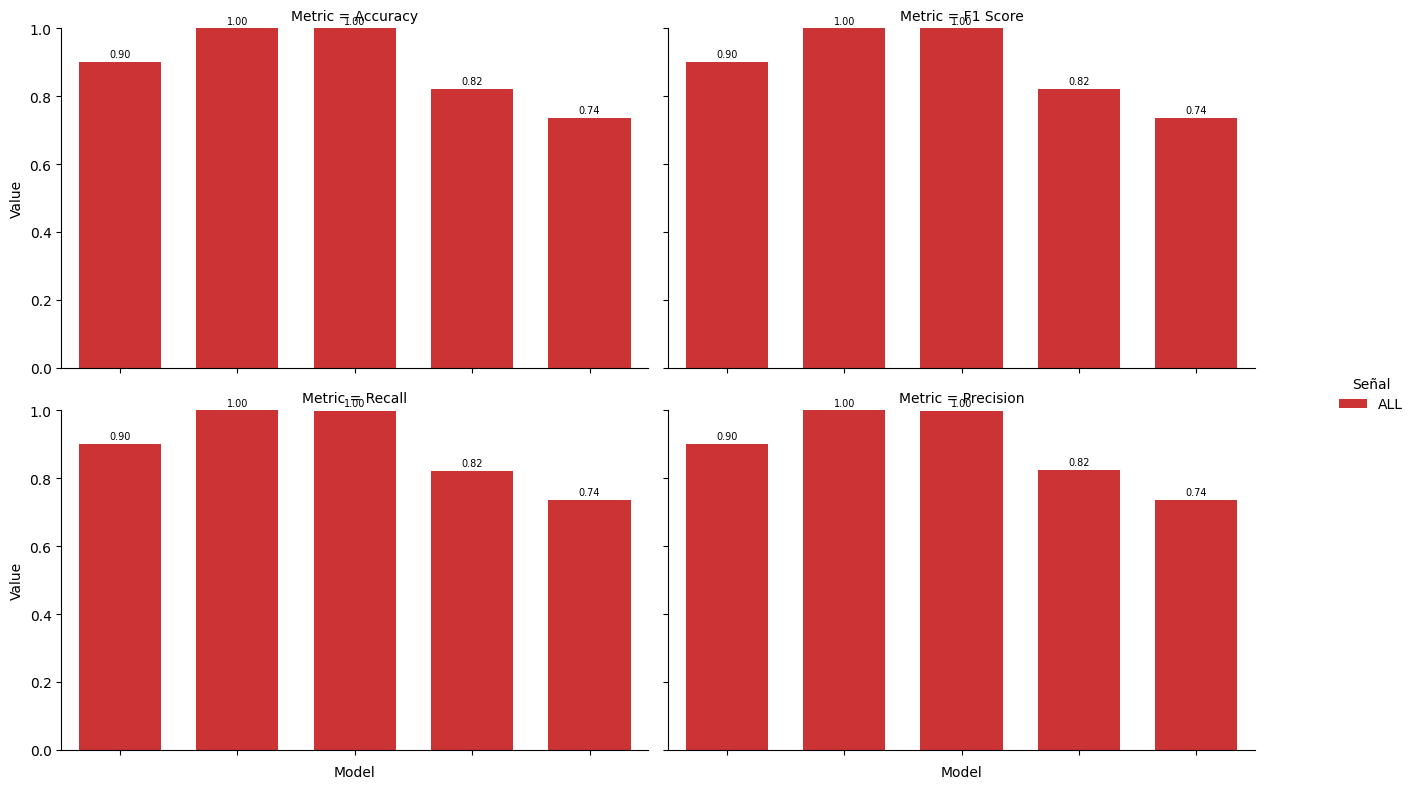

In [16]:
"""# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(signal, model_name)] = metrics.copy()"""

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate(X_all, y_all, model, param_grid, model_name, "ALL")

    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

4-CLASIFICATION

In [17]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [18]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 21943
Label: 2 total: 8973
Label: 3 total: 21939
Label: 4 total: 13869


Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.662121  ALL - DecisionTree
1  Precision  0.701403  ALL - DecisionTree
2     Recall  0.662121  ALL - DecisionTree
3   F1 Score  0.668136  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.6621
ALL - DecisionTree - Confusion Matrix
[[3629  500   64  196]
 [ 306  991  124  373]
 [ 171  524 2274 1419]
 [ 104  283  445 1942]]


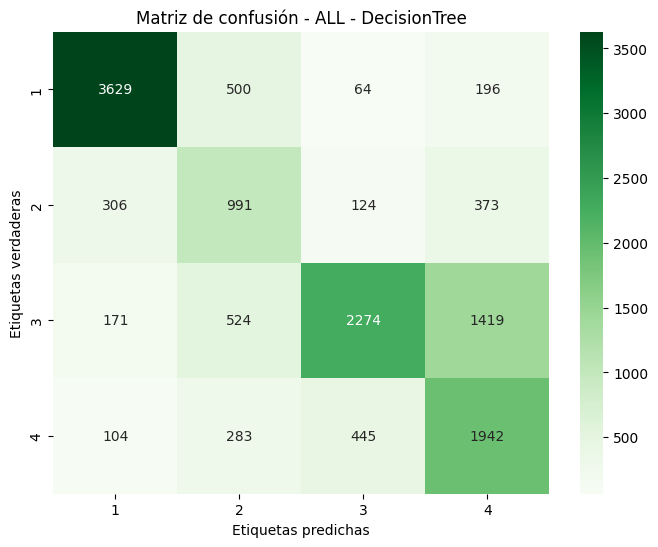

Training with ALL signals:  20%|██        | 1/5 [02:31<10:06, 151.66s/it]

              precision    recall  f1-score   support

           1       0.86      0.83      0.84      4389
           2       0.43      0.55      0.48      1794
           3       0.78      0.52      0.62      4388
           4       0.49      0.70      0.58      2774

    accuracy                           0.66     13345
   macro avg       0.64      0.65      0.63     13345
weighted avg       0.70      0.66      0.67     13345

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.999026  ALL - RandomForest
1  Precision  0.999026  ALL - RandomForest
2     Recall  0.999026  ALL - RandomForest
3   F1 Score  0.999026  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9990
ALL - RandomForest -

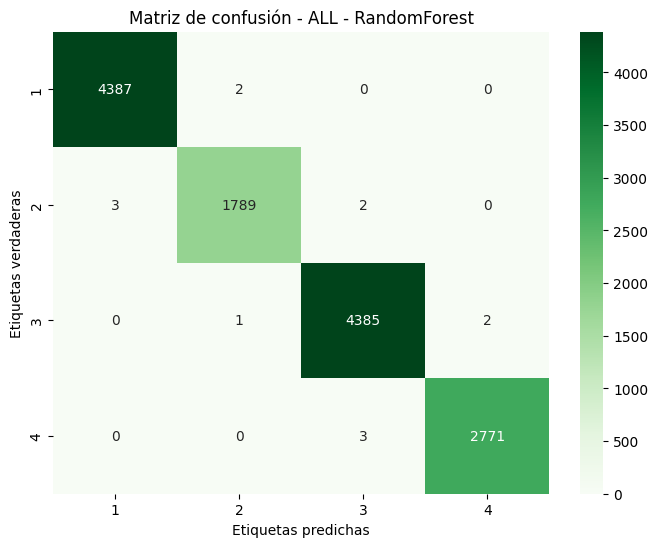

Training with ALL signals:  40%|████      | 2/5 [1:32:23<2:41:42, 3234.13s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.830199  ALL - AdaBoost
1  Precision  0.832783  ALL - AdaBoost
2     Recall  0.830199  ALL - AdaBoost
3   F1 Score  0.830476  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.8302
ALL - AdaBoost - Confusion Matrix
[[4049  329    2

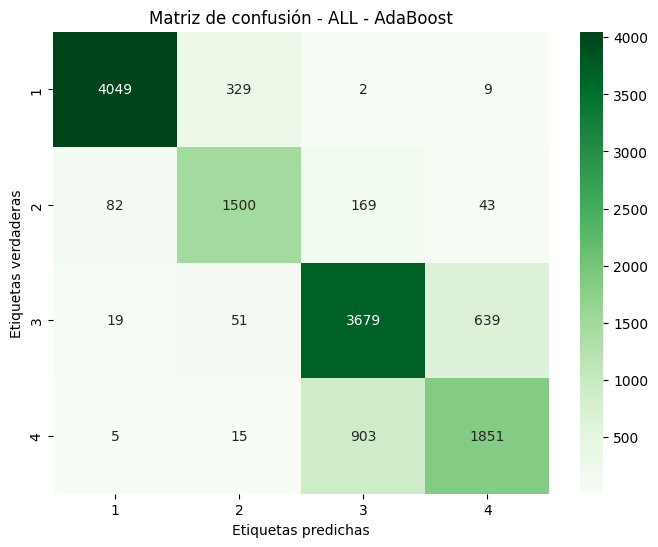

Training with ALL signals:  60%|██████    | 3/5 [2:22:38<1:44:27, 3133.96s/it]

              precision    recall  f1-score   support

           1       0.97      0.92      0.95      4389
           2       0.79      0.84      0.81      1794
           3       0.77      0.84      0.80      4388
           4       0.73      0.67      0.70      2774

    accuracy                           0.83     13345
   macro avg       0.82      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.629449  ALL - LDA
1  Precision  0.610578  ALL - LDA
2     Recall  0.629449  ALL - LDA
3   F1 Score  0.604154  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.6294
ALL - LDA - Confusion Matrix
[[3632   99  253  405]
 [ 732  256  425  381]
 [ 293   61 3307  727]
 [ 420   95 1054 1205]]


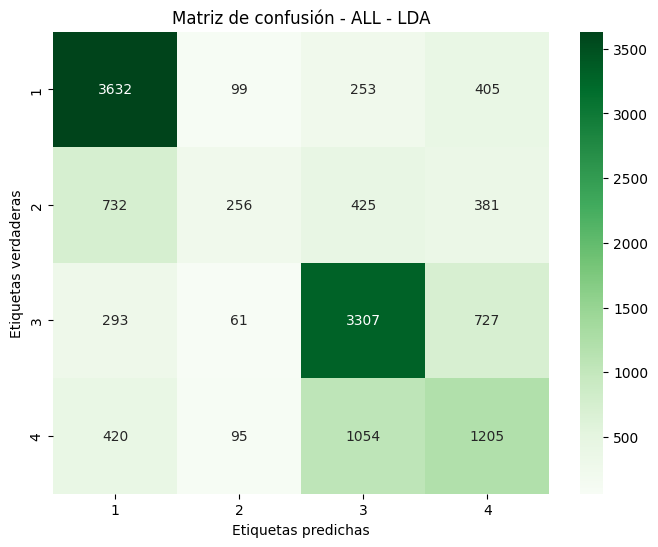

Training with ALL signals:  80%|████████  | 4/5 [2:22:42<31:38, 1898.39s/it]  

              precision    recall  f1-score   support

           1       0.72      0.83      0.77      4389
           2       0.50      0.14      0.22      1794
           3       0.66      0.75      0.70      4388
           4       0.44      0.43      0.44      2774

    accuracy                           0.63     13345
   macro avg       0.58      0.54      0.53     13345
weighted avg       0.61      0.63      0.60     13345

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.589809  ALL - KNN
1  Precision  0.586069  ALL - KNN
2     Recall  0.589809  ALL - KNN
3   F1 Score  0.587023  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.5898
ALL - KNN - Confusion Matrix
[[2995  309  687  398]
 [ 461  751  356  226]
 [ 783  344 2755  506]
 [ 564  202  638 1370]]


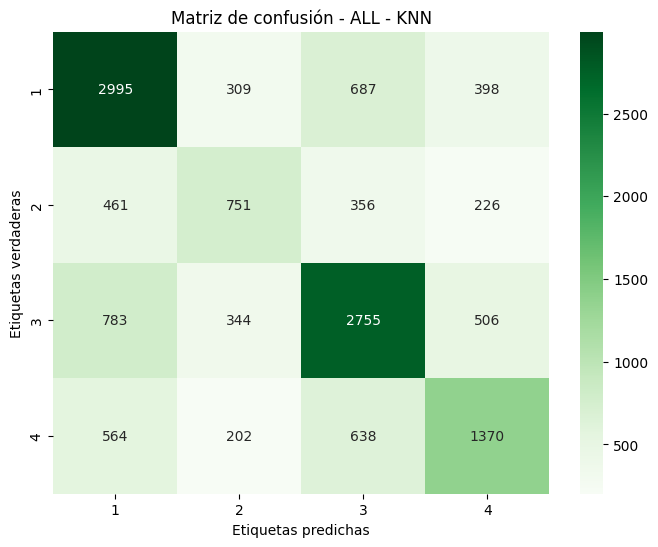

Training with ALL signals: 100%|██████████| 5/5 [2:22:54<00:00, 1714.82s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.47      0.42      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.57      0.56      0.56     13345
weighted avg       0.59      0.59      0.59     13345


Final Comparison:
ALL - DecisionTree:
     Métrica     Valor               Etapa
0   Accuracy  0.662121  ALL - DecisionTree
1  Precision  0.701403  ALL - DecisionTree
2     Recall  0.662121  ALL - DecisionTree
3   F1 Score  0.668136  ALL - DecisionTree
ALL - RandomForest:
     Métrica     Valor               Etapa
0   Accuracy  0.999026  ALL - RandomForest
1  Precision  0.999026  ALL - RandomForest
2     Recall  0.999026  ALL - RandomForest
3   F1 Score  0.999026  ALL - RandomForest
ALL - AdaBoost:
     Métrica     Valor           Etapa
0   Accuracy  0.83019

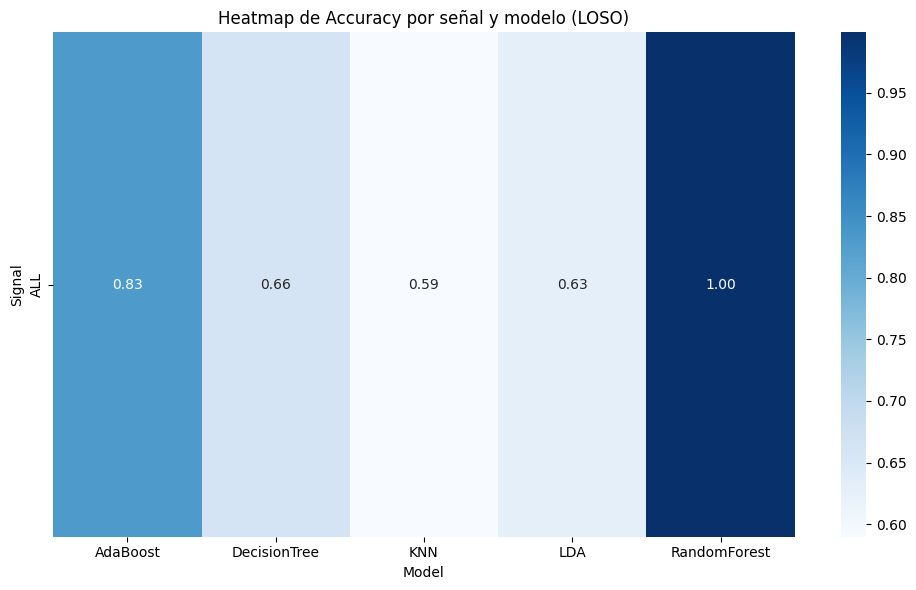

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_15152\2378078127.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

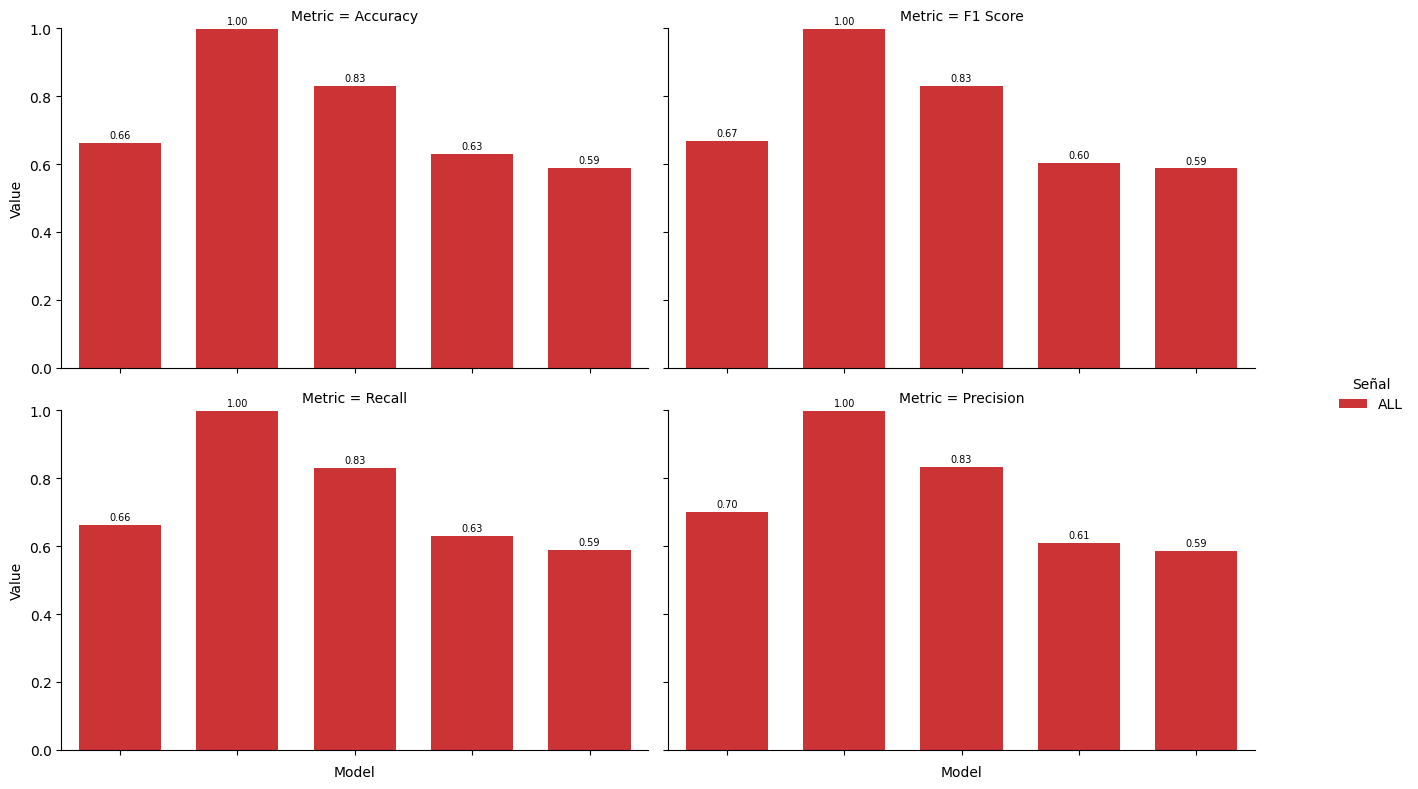

In [19]:
"""# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(signal, model_name)] = metrics.copy()"""

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate(X_all, y_all, model, param_grid, model_name, "ALL")

    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [20]:
print(wa)

NameError: name 'wa' is not defined

Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.4266
ECG - DecisionTree - Confusion Matrix
[[6270   15  231   67]
 [2297  230  114   51]
 [4466  228 1473  415]
 [3266   78  249  567]]


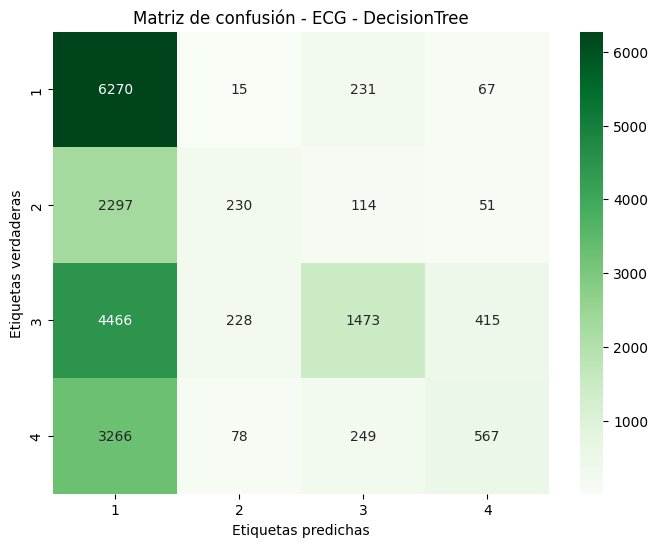

              precision    recall  f1-score   support

           1       0.38      0.95      0.55      6583
           2       0.42      0.09      0.14      2692
           3       0.71      0.22      0.34      6582
           4       0.52      0.14      0.22      4160

    accuracy                           0.43     20017
   macro avg       0.51      0.35      0.31     20017
weighted avg       0.52      0.43      0.36     20017

Training RandomForest model for ECG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.9425
ECG - RandomForest - Confusion Matrix
[[6393   21  114   55]
 [ 203 2322  127   40]
 

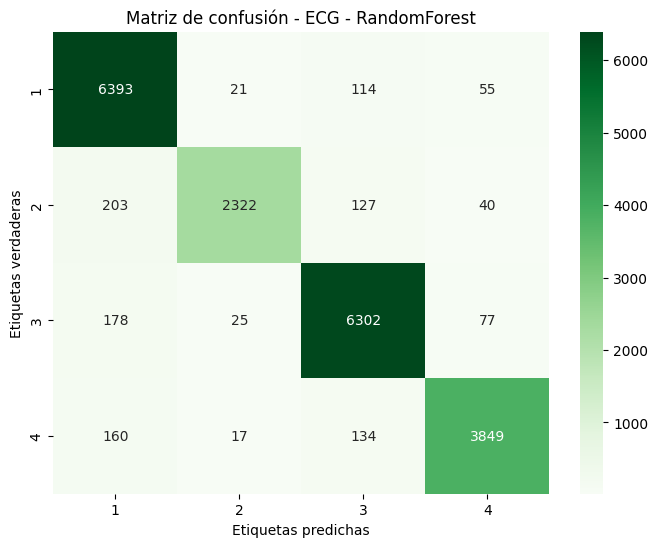

              precision    recall  f1-score   support

           1       0.92      0.97      0.95      6583
           2       0.97      0.86      0.91      2692
           3       0.94      0.96      0.95      6582
           4       0.96      0.93      0.94      4160

    accuracy                           0.94     20017
   macro avg       0.95      0.93      0.94     20017
weighted avg       0.94      0.94      0.94     20017

Training AdaBoost model for ECG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.586152  ECG - AdaBoost
1  Precision  0.581555  ECG - AdaBoost
2     Recall  0.586152  ECG - AdaBoost
3   F1 Score  0.580388  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.5862
ECG - AdaBoost - Confusion Matrix
[[4478  615  995  495]
 [ 947  885  631  229]
 [1388  285 

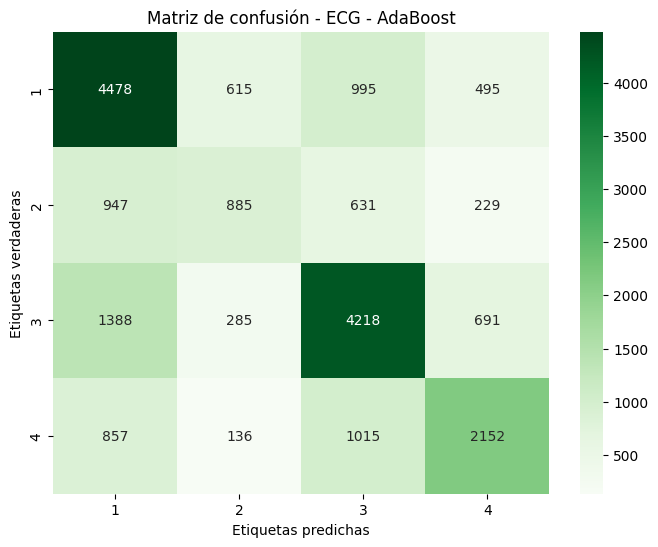

              precision    recall  f1-score   support

           1       0.58      0.68      0.63      6583
           2       0.46      0.33      0.38      2692
           3       0.61      0.64      0.63      6582
           4       0.60      0.52      0.56      4160

    accuracy                           0.59     20017
   macro avg       0.57      0.54      0.55     20017
weighted avg       0.58      0.59      0.58     20017

Training LDA model for ECG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.415197  ECG - LDA
1  Precision  0.417248  ECG - LDA
2     Recall  0.415197  ECG - LDA
3   F1 Score  0.358256  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.4152
ECG - LDA - Confusion Matrix
[[4671    8 1578  326]
 [1610   11  925  146]
 [2983    3 3145  451]
 [2123    0 1553  484]]


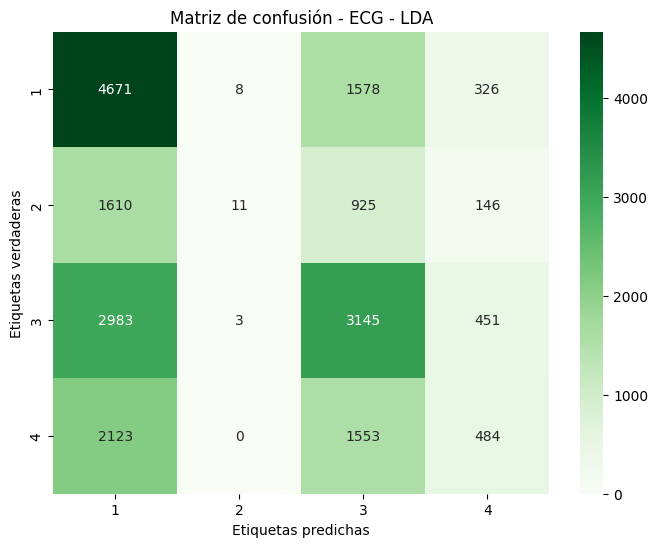

              precision    recall  f1-score   support

           1       0.41      0.71      0.52      6583
           2       0.50      0.00      0.01      2692
           3       0.44      0.48      0.46      6582
           4       0.34      0.12      0.17      4160

    accuracy                           0.42     20017
   macro avg       0.42      0.33      0.29     20017
weighted avg       0.42      0.42      0.36     20017

Training KNN model for ECG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.657541  ECG - KNN
1  Precision  0.655851  ECG - KNN
2     Recall  0.657541  ECG - KNN
3   F1 Score  0.655284  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.6575
ECG - KNN - Confusion Matrix
[[4809  326  942  506]
 [ 567 1394  507  224]
 [1073  323 4556  630]
 [ 774  224  759 2403]]


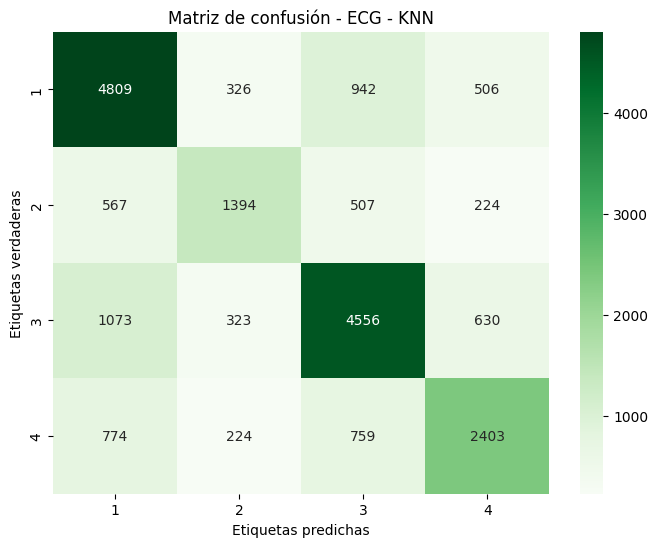

Training by signal:  25%|██▌       | 1/4 [44:06<2:12:20, 2646.71s/it]

              precision    recall  f1-score   support

           1       0.67      0.73      0.70      6583
           2       0.61      0.52      0.56      2692
           3       0.67      0.69      0.68      6582
           4       0.64      0.58      0.61      4160

    accuracy                           0.66     20017
   macro avg       0.65      0.63      0.64     20017
weighted avg       0.66      0.66      0.66     20017

Training DecisionTree model for PPG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.589749  PPG - DecisionTree
1  Precision  0.657386  PPG - DecisionTree
2     Recall  0.589749  PPG - DecisionTree
3   F1 Score  0.611145  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.5897
PPG - DecisionTree - Confusion Matrix
[[4480 1182  122  799]
 [ 6

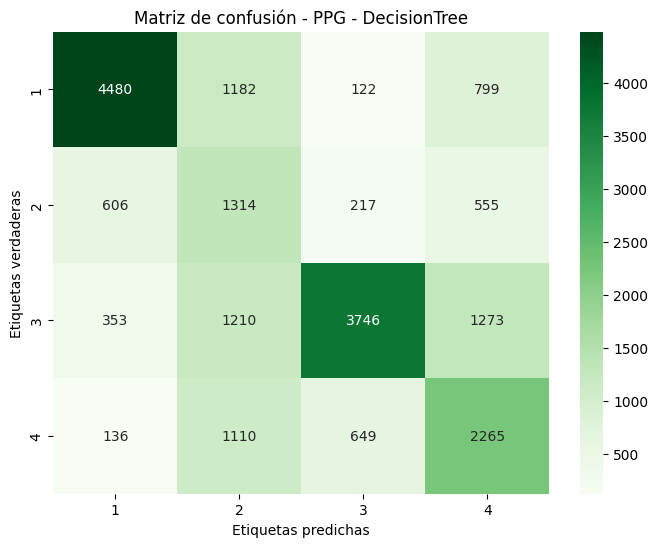

              precision    recall  f1-score   support

           1       0.80      0.68      0.74      6583
           2       0.27      0.49      0.35      2692
           3       0.79      0.57      0.66      6582
           4       0.46      0.54      0.50      4160

    accuracy                           0.59     20017
   macro avg       0.58      0.57      0.56     20017
weighted avg       0.66      0.59      0.61     20017

Training RandomForest model for PPG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.995204  PPG - RandomForest
1  Precision  0.995213  PPG - RandomForest
2     Recall  0.995204  PPG - RandomForest
3   F1 Score  0.995199  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9952
PPG - RandomForest - Confusion Matrix
[[6574    2    2    5]
 [  27 2652    9    4]
 

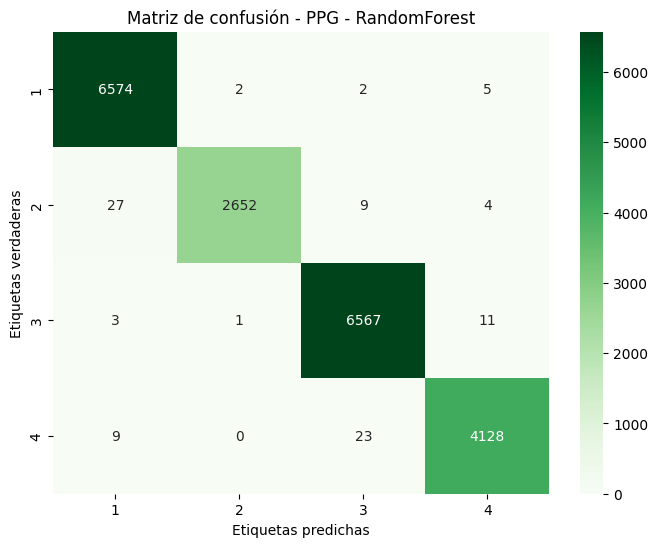

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      1.00      6582
           4       1.00      0.99      0.99      4160

    accuracy                           1.00     20017
   macro avg       1.00      0.99      0.99     20017
weighted avg       1.00      1.00      1.00     20017

Training AdaBoost model for PPG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.774192  PPG - AdaBoost
1  Precision  0.775871  PPG - AdaBoost
2     Recall  0.774192  PPG - AdaBoost
3   F1 Score  0.774591  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.7742
PPG - AdaBoost - Confusion Matrix
[[5728  562  141  152]
 [ 520 1599  283  290]
 [ 153  213 

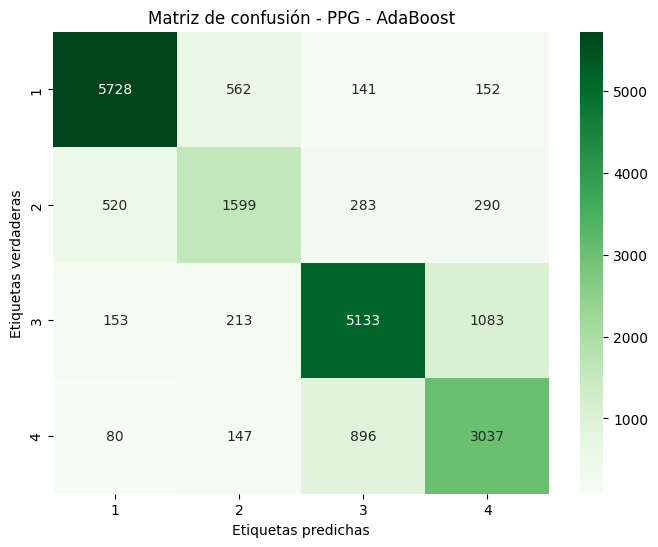

              precision    recall  f1-score   support

           1       0.88      0.87      0.88      6583
           2       0.63      0.59      0.61      2692
           3       0.80      0.78      0.79      6582
           4       0.67      0.73      0.70      4160

    accuracy                           0.77     20017
   macro avg       0.74      0.74      0.74     20017
weighted avg       0.78      0.77      0.77     20017

Training LDA model for PPG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.561573  PPG - LDA
1  Precision  0.519806  PPG - LDA
2     Recall  0.561573  PPG - LDA
3   F1 Score  0.508671  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.5616
PPG - LDA - Confusion Matrix
[[5087   28  773  695]
 [1208   29  919  536]
 [ 670    4 5105  803]
 [ 767   16 2357 1020]]


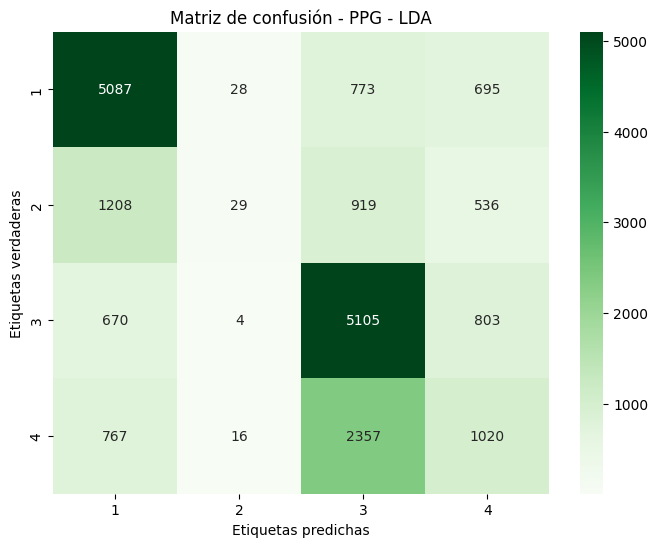

              precision    recall  f1-score   support

           1       0.66      0.77      0.71      6583
           2       0.38      0.01      0.02      2692
           3       0.56      0.78      0.65      6582
           4       0.33      0.25      0.28      4160

    accuracy                           0.56     20017
   macro avg       0.48      0.45      0.42     20017
weighted avg       0.52      0.56      0.51     20017

Training KNN model for PPG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.882949  PPG - KNN
1  Precision  0.882701  PPG - KNN
2     Recall  0.882949  PPG - KNN
3   F1 Score  0.882814  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.8829
PPG - KNN - Confusion Matrix
[[6066  182  170  165]
 [ 207 2170  159  156]
 [ 137  176 5944  325]
 [ 198  121  347 3494]]


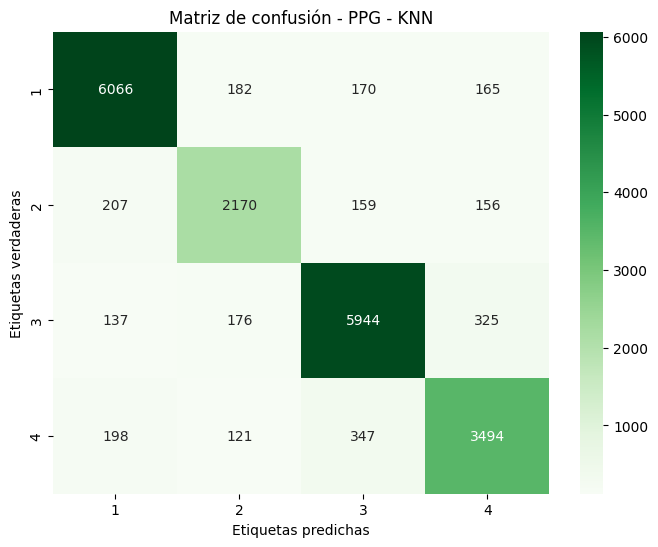

Training by signal:  50%|█████     | 2/4 [1:26:26<1:26:07, 2583.98s/it]

              precision    recall  f1-score   support

           1       0.92      0.92      0.92      6583
           2       0.82      0.81      0.81      2692
           3       0.90      0.90      0.90      6582
           4       0.84      0.84      0.84      4160

    accuracy                           0.88     20017
   macro avg       0.87      0.87      0.87     20017
weighted avg       0.88      0.88      0.88     20017

Training DecisionTree model for EDA...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.518559  EDA - DecisionTree
1  Precision  0.592203  EDA - DecisionTree
2     Recall  0.518559  EDA - DecisionTree
3   F1 Score  0.531905  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.5186
EDA - DecisionTree - Confusion Matrix
[[3474 1106  747 1256]
 [ 2

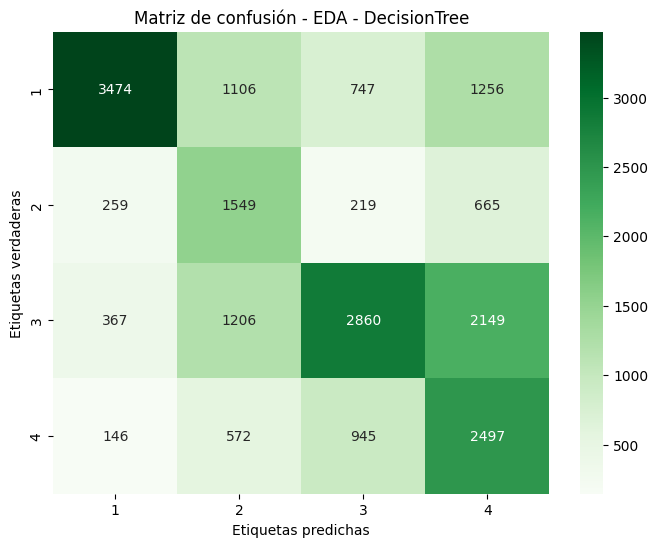

              precision    recall  f1-score   support

           1       0.82      0.53      0.64      6583
           2       0.35      0.58      0.43      2692
           3       0.60      0.43      0.50      6582
           4       0.38      0.60      0.47      4160

    accuracy                           0.52     20017
   macro avg       0.54      0.53      0.51     20017
weighted avg       0.59      0.52      0.53     20017

Training RandomForest model for EDA...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.992656  EDA - RandomForest
1  Precision  0.992669  EDA - RandomForest
2     Recall  0.992656  EDA - RandomForest
3   F1 Score  0.992653  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9927
EDA - RandomForest - Confusion Matrix
[[6553    5   18    7]
 [  18 2656   12    6]
 

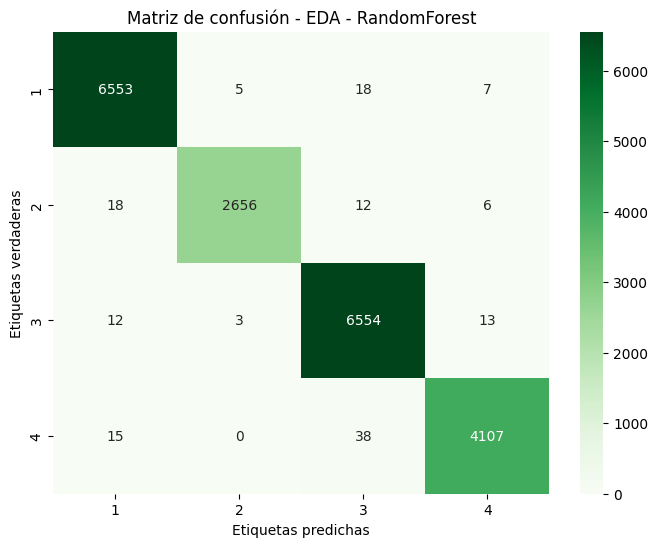

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for EDA...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.640605  EDA - AdaBoost
1  Precision  0.660503  EDA - AdaBoost
2     Recall  0.640605  EDA - AdaBoost
3   F1 Score  0.646235  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.6406
EDA - AdaBoost - Confusion Matrix
[[4104 1329  759  391]
 [ 435 1564  348  345]
 [ 516  589 

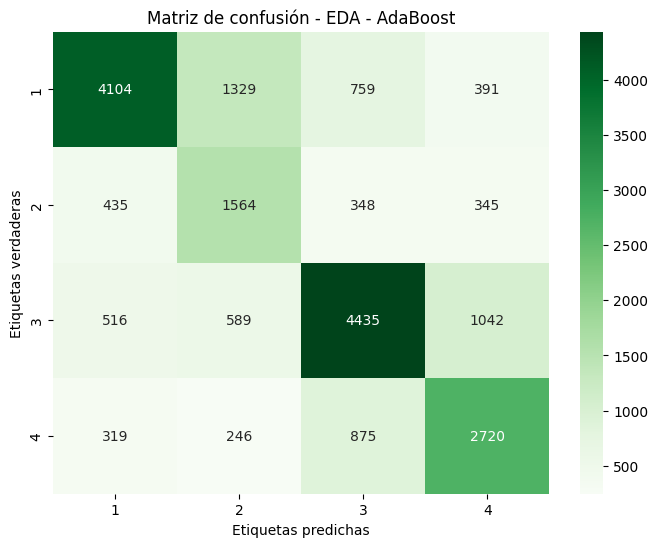

              precision    recall  f1-score   support

           1       0.76      0.62      0.69      6583
           2       0.42      0.58      0.49      2692
           3       0.69      0.67      0.68      6582
           4       0.60      0.65      0.63      4160

    accuracy                           0.64     20017
   macro avg       0.62      0.63      0.62     20017
weighted avg       0.66      0.64      0.65     20017

Training LDA model for EDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.417995  EDA - LDA
1  Precision  0.417615  EDA - LDA
2     Recall  0.417995  EDA - LDA
3   F1 Score  0.350615  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4180
EDA - LDA - Confusion Matrix
[[4872    3 1455  253]
 [1466    7 1122   97]
 [3132    0 3182  268]
 [1850    3 2001  306]]


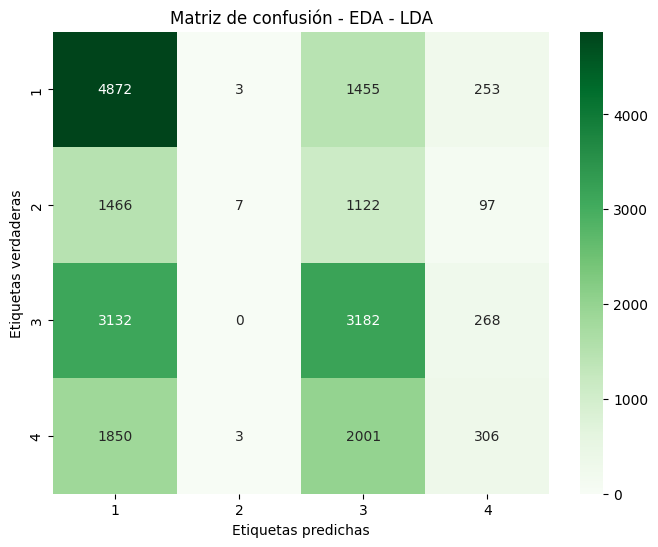

              precision    recall  f1-score   support

           1       0.43      0.74      0.54      6583
           2       0.54      0.00      0.01      2692
           3       0.41      0.48      0.44      6582
           4       0.33      0.07      0.12      4160

    accuracy                           0.42     20017
   macro avg       0.43      0.32      0.28     20017
weighted avg       0.42      0.42      0.35     20017

Training KNN model for EDA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.923115  EDA - KNN
1  Precision  0.923083  EDA - KNN
2     Recall  0.923115  EDA - KNN
3   F1 Score  0.923096  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.9231
EDA - KNN - Confusion Matrix
[[6205  107  166  105]
 [ 105 2427  100   60]
 [ 189   94 6088  211]
 [ 107   68  227 3758]]


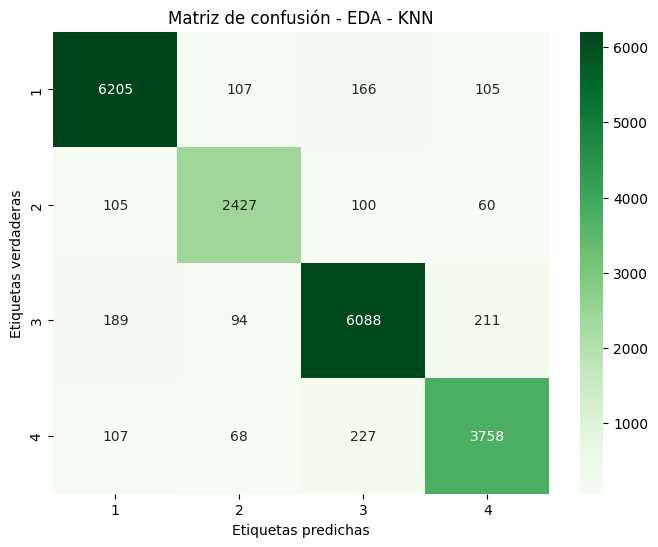

Training by signal:  75%|███████▌  | 3/4 [2:00:41<39:02, 2342.25s/it]  

              precision    recall  f1-score   support

           1       0.94      0.94      0.94      6583
           2       0.90      0.90      0.90      2692
           3       0.93      0.92      0.93      6582
           4       0.91      0.90      0.91      4160

    accuracy                           0.92     20017
   macro avg       0.92      0.92      0.92     20017
weighted avg       0.92      0.92      0.92     20017

Training DecisionTree model for RESP...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.454064  RESP - DecisionTree
1  Precision  0.475188  RESP - DecisionTree
2     Recall  0.454064  RESP - DecisionTree
3   F1 Score  0.453421  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.4541
RESP - DecisionTree - Confusion Matrix
[[2399 1299 1615 

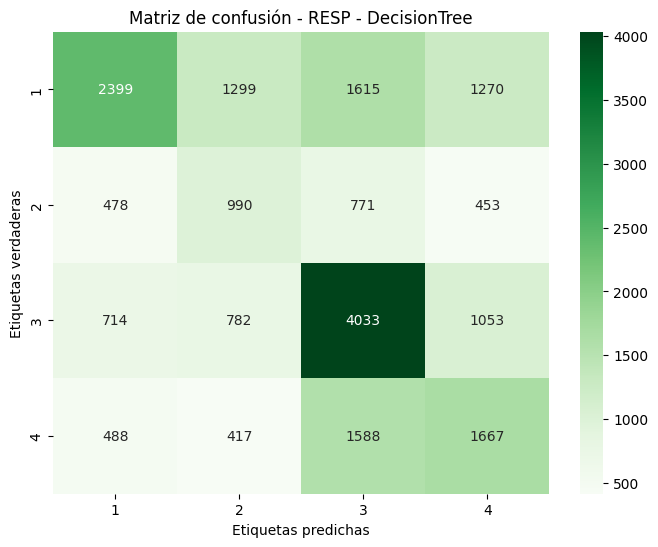

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for RESP...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.991807  RESP - RandomForest
1  Precision  0.991833  RESP - RandomForest
2     Recall  0.991807  RESP - RandomForest
3   F1 Score  0.991806  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9918
RESP - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  13 2658   

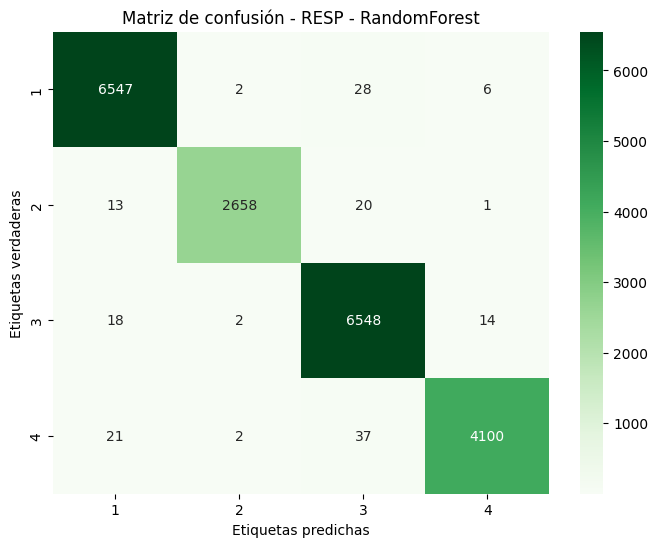

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for RESP...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.676475  RESP - AdaBoost
1  Precision  0.680425  RESP - AdaBoost
2     Recall  0.676475  RESP - AdaBoost
3   F1 Score  0.672559  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.6765
RESP - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445  125]
 [

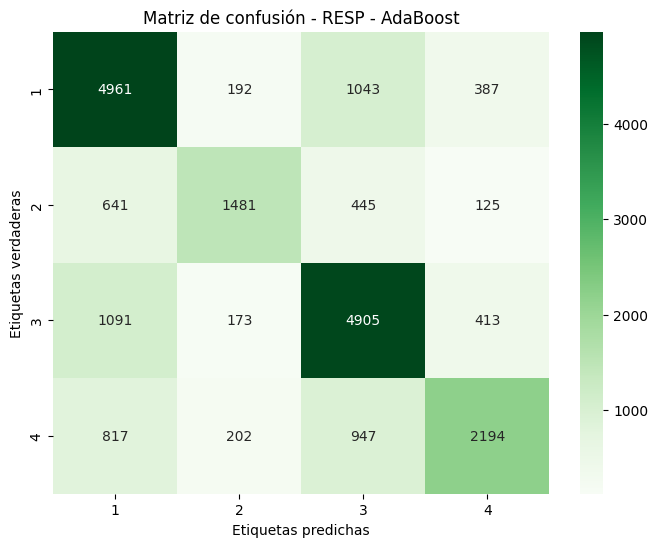

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for RESP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.438477  RESP - LDA
1  Precision  0.496975  RESP - LDA
2     Recall  0.438477  RESP - LDA
3   F1 Score  0.363873  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.4385
RESP - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


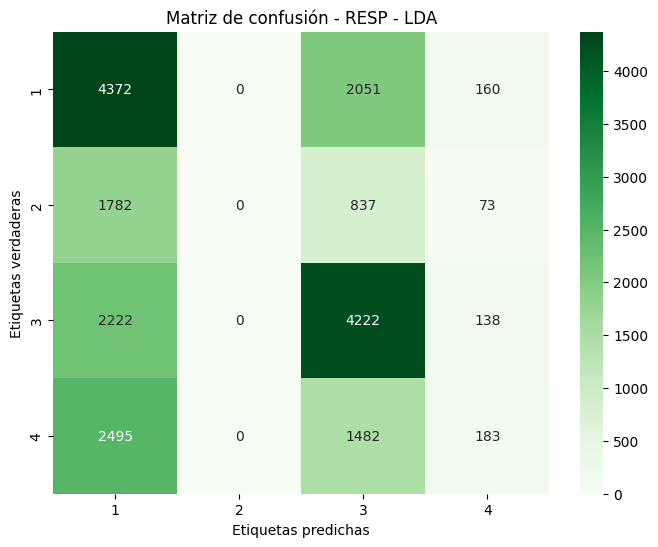

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for RESP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.976670  RESP - KNN
1  Precision  0.976686  RESP - KNN
2     Recall  0.976670  RESP - KNN
3   F1 Score  0.976669  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9767
RESP - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


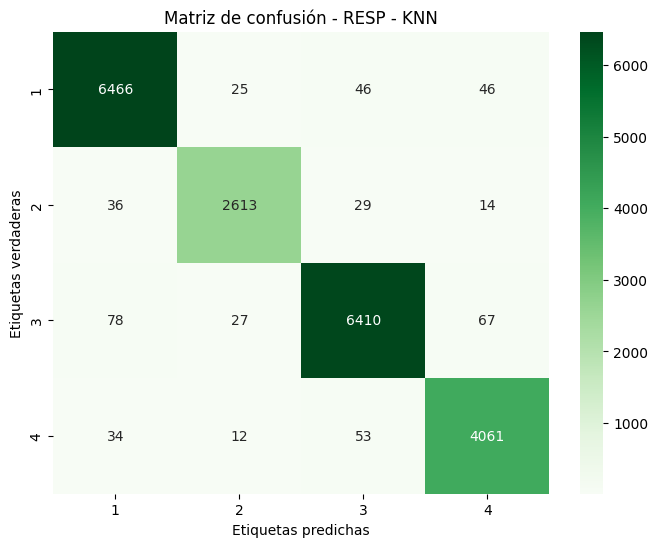

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.454064  ALL - DecisionTree
1  Precision  0.475188  ALL - DecisionTree
2     Recall  0.454064  ALL - DecisionTree
3   F1 Score  0.453421  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.4541
ALL - DecisionTree - Confusion Matrix
[[2399 1299 1615 1270]
 [ 478  990  771  453]
 [ 714  782 4033 1053]
 [ 488  417 1588 1667]]


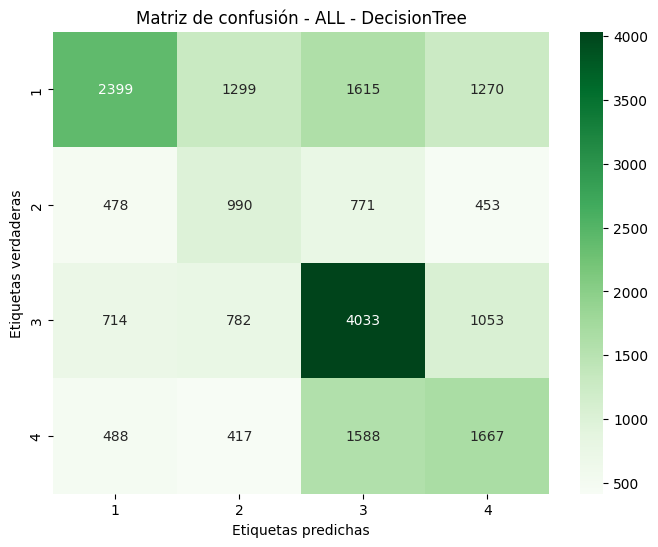

Training with ALL signals:  20%|██        | 1/5 [00:30<02:03, 30.80s/it]

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.991807  ALL - RandomForest
1  Precision  0.991833  ALL - RandomForest
2     Recall  0.991807  ALL - RandomForest
3   F1 Score  0.991806  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9918
ALL - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  1

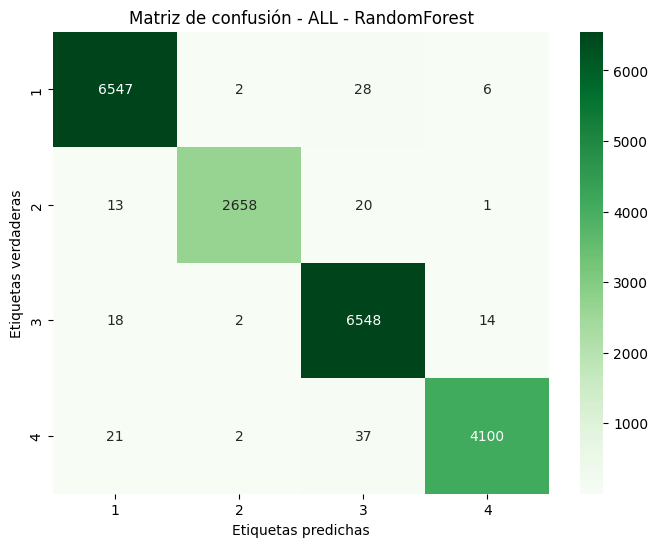

Training with ALL signals:  40%|████      | 2/5 [15:54<27:48, 556.00s/it]

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.676475  ALL - AdaBoost
1  Precision  0.680425  ALL - AdaBoost
2     Recall  0.676475  ALL - AdaBoost
3   F1 Score  0.672559  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.6765
ALL - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445

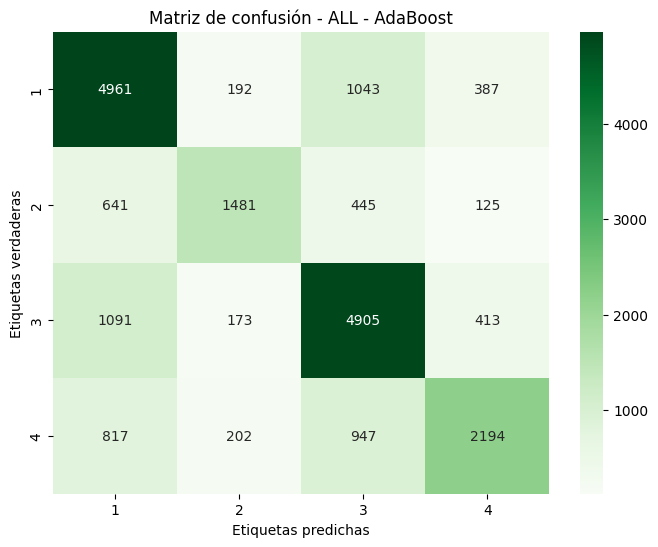

Training with ALL signals:  60%|██████    | 3/5 [28:25<21:30, 645.01s/it]

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.438477  ALL - LDA
1  Precision  0.496975  ALL - LDA
2     Recall  0.438477  ALL - LDA
3   F1 Score  0.363873  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.4385
ALL - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


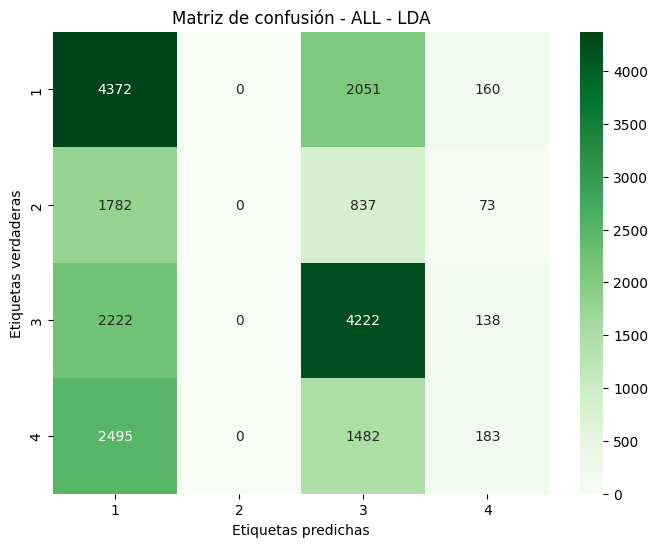

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training with ALL signals

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.976670  ALL - KNN
1  Precision  0.976686  ALL - KNN
2     Recall  0.976670  ALL - KNN
3   F1 Score  0.976669  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.9767
ALL - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


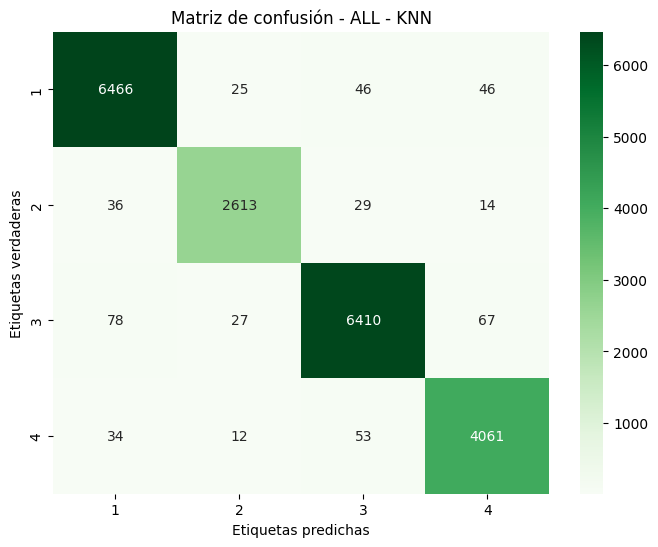

Training with ALL signals: 100%|██████████| 5/5 [28:28<00:00, 341.70s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017


Final Comparison:
ECG - DecisionTree:      Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
ECG - RandomForest:      Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
ECG - AdaBoost:      Métrica     Valor           Etapa
0   Accuracy  0.58615

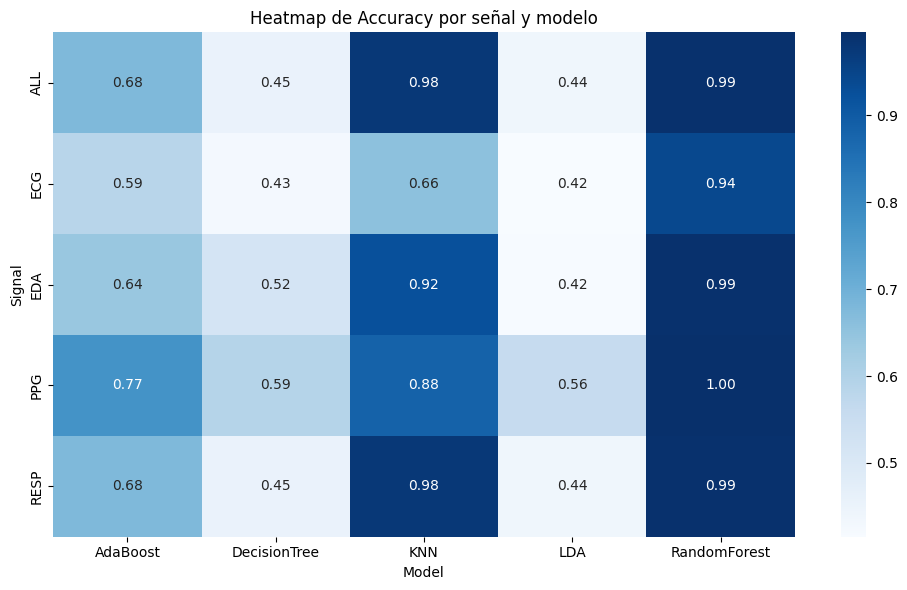

In [ ]:
"""# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO
        
        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal}...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    acc = train_and_evaluate(X, y, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = acc

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}: {acc}')

rows = []

for (signal, model), df_metrics in results.items():
    # Convertimos el DataFrame a formato entendible
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo')
plt.tight_layout()
plt.show()"""

In [ ]:
print(terminado)

In [ ]:
import pandas as pd

data = [
    ["ECG", "DecisionTree", "Accuracy", 0.426637],
    ["ECG", "DecisionTree", "Precision", 0.524099],
    ["ECG", "DecisionTree", "Recall", 0.426637],
    ["ECG", "DecisionTree", "F1 Score", 0.356113],
    
    ["ECG", "RandomForest", "Accuracy", 0.942499],
    ["ECG", "RandomForest", "Precision", 0.943431],
    ["ECG", "RandomForest", "Recall", 0.942499],
    ["ECG", "RandomForest", "F1 Score", 0.942231],
    
    ["ECG", "AdaBoost", "Accuracy", 0.586152],
    ["ECG", "AdaBoost", "Precision", 0.581555],
    ["ECG", "AdaBoost", "Recall", 0.586152],
    ["ECG", "AdaBoost", "F1 Score", 0.580388],
    
    ["ECG", "LDA", "Accuracy", 0.415197],
    ["ECG", "LDA", "Precision", 0.417248],
    ["ECG", "LDA", "Recall", 0.415197],
    ["ECG", "LDA", "F1 Score", 0.358256],
    
    ["ECG", "KNN", "Accuracy", 0.657541],
    ["ECG", "KNN", "Precision", 0.655851],
    ["ECG", "KNN", "Recall", 0.657541],
    ["ECG", "KNN", "F1 Score", 0.655284],
    
    ["PPG", "DecisionTree", "Accuracy", 0.589749],
    ["PPG", "DecisionTree", "Precision", 0.657386],
    ["PPG", "DecisionTree", "Recall", 0.589749],
    ["PPG", "DecisionTree", "F1 Score", 0.611145],
    
    ["PPG", "RandomForest", "Accuracy", 0.995204],
    ["PPG", "RandomForest", "Precision", 0.995213],
    ["PPG", "RandomForest", "Recall", 0.995204],
    ["PPG", "RandomForest", "F1 Score", 0.995199],
    
    ["PPG", "AdaBoost", "Accuracy", 0.774192],
    ["PPG", "AdaBoost", "Precision", 0.775871],
    ["PPG", "AdaBoost", "Recall", 0.774192],
    ["PPG", "AdaBoost", "F1 Score", 0.774591],
    
    ["PPG", "LDA", "Accuracy", 0.561573],
    ["PPG", "LDA", "Precision", 0.519806],
    ["PPG", "LDA", "Recall", 0.561573],
    ["PPG", "LDA", "F1 Score", 0.508671],
    
    ["PPG", "KNN", "Accuracy", 0.882949],
    ["PPG", "KNN", "Precision", 0.882701],
    ["PPG", "KNN", "Recall", 0.882949],
    ["PPG", "KNN", "F1 Score", 0.882814],
    
    ["EDA", "DecisionTree", "Accuracy", 0.518559],
    ["EDA", "DecisionTree", "Precision", 0.592203],
    ["EDA", "DecisionTree", "Recall", 0.518559],
    ["EDA", "DecisionTree", "F1 Score", 0.531905],
    
    ["EDA", "RandomForest", "Accuracy", 0.992656],
    ["EDA", "RandomForest", "Precision", 0.992669],
    ["EDA", "RandomForest", "Recall", 0.992656],
    ["EDA", "RandomForest", "F1 Score", 0.992653],
    
    ["EDA", "AdaBoost", "Accuracy", 0.640605],
    ["EDA", "AdaBoost", "Precision", 0.660503],
    ["EDA", "AdaBoost", "Recall", 0.640605],
    ["EDA", "AdaBoost", "F1 Score", 0.646235],
    
    ["EDA", "LDA", "Accuracy", 0.417995],
    ["EDA", "LDA", "Precision", 0.417615],
    ["EDA", "LDA", "Recall", 0.417995],
    ["EDA", "LDA", "F1 Score", 0.350615],
    
    ["EDA", "KNN", "Accuracy", 0.923115],
    ["EDA", "KNN", "Precision", 0.923083],
    ["EDA", "KNN", "Recall", 0.923115],
    ["EDA", "KNN", "F1 Score", 0.923096],
    
    ["RESP", "DecisionTree", "Accuracy", 0.454064],
    ["RESP", "DecisionTree", "Precision", 0.475188],
    ["RESP", "DecisionTree", "Recall", 0.454064],
    ["RESP", "DecisionTree", "F1 Score", 0.453421],
    
    ["RESP", "RandomForest", "Accuracy", 0.991807],
    ["RESP", "RandomForest", "Precision", 0.991833],
    ["RESP", "RandomForest", "Recall", 0.991807],
    ["RESP", "RandomForest", "F1 Score", 0.991806],
    
    ["RESP", "AdaBoost", "Accuracy", 0.676475],
    ["RESP", "AdaBoost", "Precision", 0.680425],
    ["RESP", "AdaBoost", "Recall", 0.676475],
    ["RESP", "AdaBoost", "F1 Score", 0.672559],
    
    ["RESP", "LDA", "Accuracy", 0.438477],
    ["RESP", "LDA", "Precision", 0.496975],
    ["RESP", "LDA", "Recall", 0.438477],
    ["RESP", "LDA", "F1 Score", 0.363873],
    
    ["RESP", "KNN", "Accuracy", 0.976670],
    ["RESP", "KNN", "Precision", 0.976686],
    ["RESP", "KNN", "Recall", 0.976670],
    ["RESP", "KNN", "F1 Score", 0.976669],
    
    ["ALL", "DecisionTree", "Accuracy", 0.454064],
    ["ALL", "DecisionTree", "Precision", 0.475188],
    ["ALL", "DecisionTree", "Recall", 0.454064],
    ["ALL", "DecisionTree", "F1 Score", 0.453421],
    
    ["ALL", "RandomForest", "Accuracy", 0.991807],
    ["ALL", "RandomForest", "Precision", 0.991833],
    ["ALL", "RandomForest", "Recall", 0.991807],
    ["ALL", "RandomForest", "F1 Score", 0.991806],
    
    ["ALL", "AdaBoost", "Accuracy", 0.676475],
    ["ALL", "AdaBoost", "Precision", 0.680425],
    ["ALL", "AdaBoost", "Recall", 0.676475],
    ["ALL", "AdaBoost", "F1 Score", 0.672559],
    
    ["ALL", "LDA", "Accuracy", 0.438477],
    ["ALL", "LDA", "Precision", 0.496975],
    ["ALL", "LDA", "Recall", 0.438477],
    ["ALL", "LDA", "F1 Score", 0.363873],
    
    ["ALL", "KNN", "Accuracy", 0.976670],
    ["ALL", "KNN", "Precision", 0.976686],
    ["ALL", "KNN", "Recall", 0.976670],
    ["ALL", "KNN", "F1 Score", 0.976669],
]

df = pd.DataFrame(data, columns=["Señal", "Modelo", "Métrica", "Valor"])

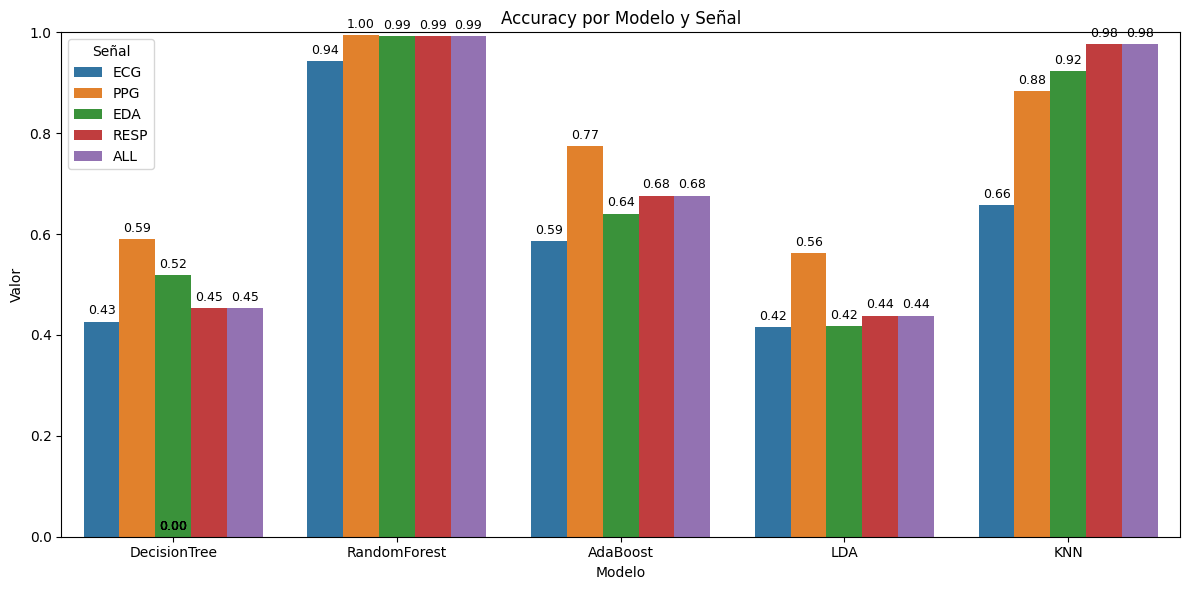

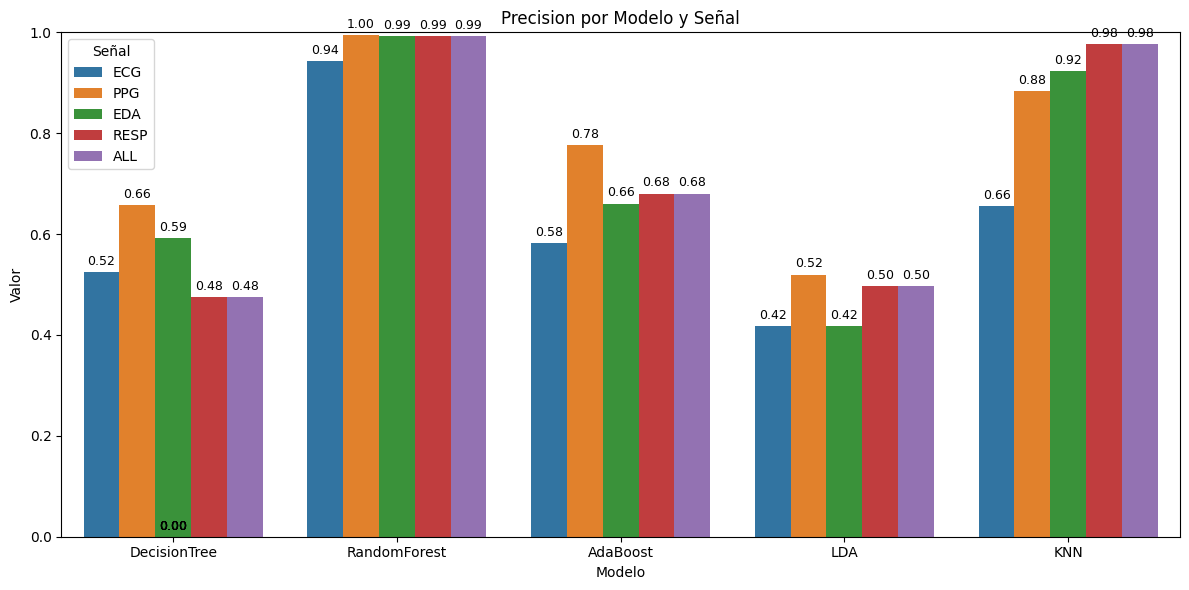

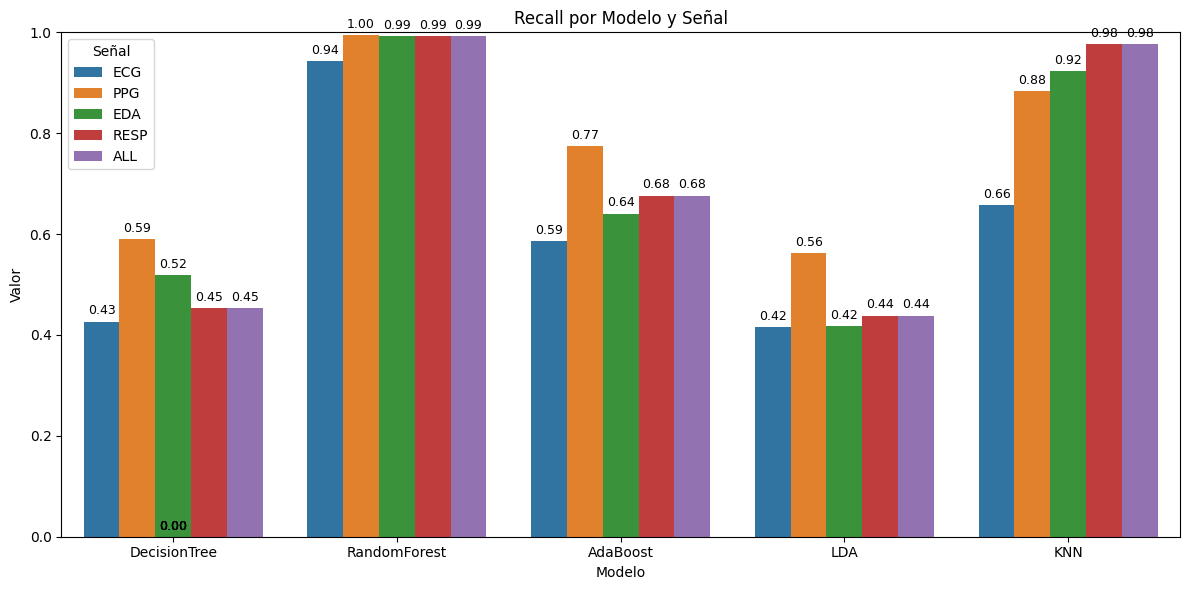

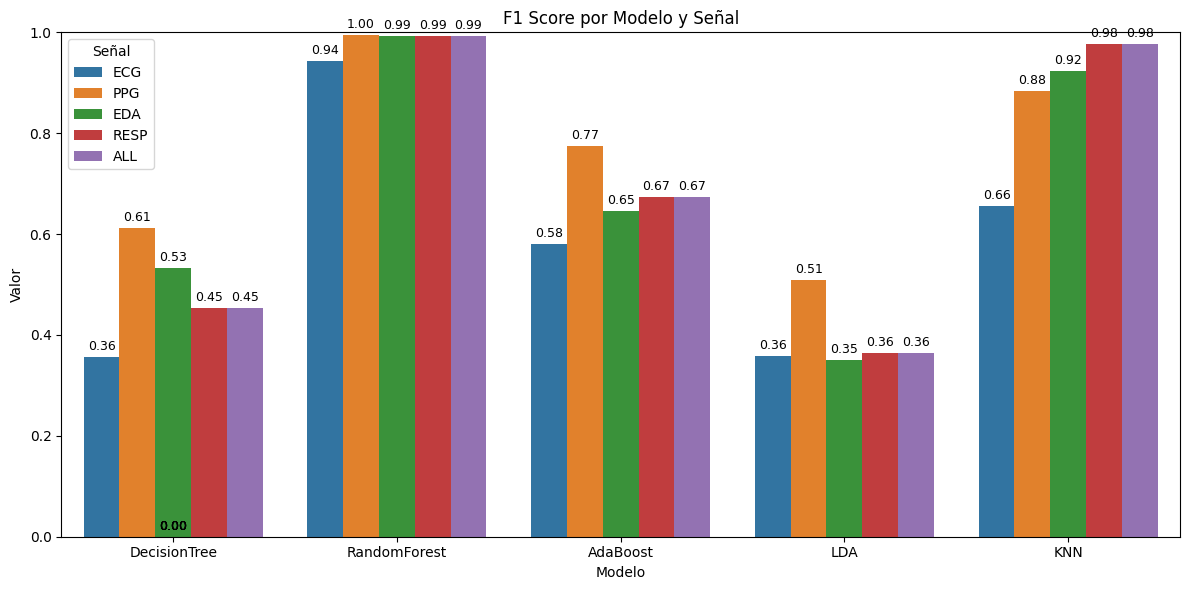

In [ ]:
metricas = df["Métrica"].unique()

# Una figura por métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    data_metrica = df[df["Métrica"] == metrica]
    ax = sns.barplot(data=data_metrica, x="Modelo", y="Valor", hue="Señal")
    
    plt.title(f"{metrica} por Modelo y Señal")
    plt.ylim(0, 1)
    plt.legend(title="Señal")
    plt.tight_layout()

    # Añadir los valores encima de las barras
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=9, color='black', xytext=(0, 3),
                        textcoords='offset points')

    plt.show()

*RANDOM FOREST*

In [ ]:
param_gridrRD = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

randomfor_model = RandomForestClassifier(random_state=random)

print("Sin balanceo")
train_and_evaluate(randomfor_model, param_gridrRD, X_train, y_train, X_test, y_test)

Sin balanceo


NameError: name 'X_train' is not defined

*ADA BOOST*

In [ ]:
param_gridADA = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

base_estimator = DecisionTreeClassifier(random_state=random)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=random)

train_and_evaluate(adaboost_model, param_gridADA, X_train, y_train, X_test, y_test)

*KNN*

In [ ]:
param_gridKNN = {
    'n_neighbors': [2, 3, 4, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_model = KNeighborsClassifier()

train_and_evaluate(knn_model, param_gridKNN, X_train, y_train, X_test, y_test)

*DECISION TREE*

In [ ]:
param_gridDT = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'max_depth': [None, 3, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en una hoja
    'max_features': ['sqrt', 'log2', None]  # Número de características a considerar en cada división
}

decision_tree_model = DecisionTreeClassifier(random_state=random)

train_and_evaluate(decision_tree_model, param_gridDT, X_train, y_train, X_test, y_test)

*LDA*

In [ ]:
param_gridLDA = {
    'solver': ['lsqr', 'eigen'],  # Excluye 'svd'
    'shrinkage': ['auto', 0.1, 0.5, 1.0]  # Compatible con 'lsqr' y 'eigen'
}

lda_model = LinearDiscriminantAnalysis()

train_and_evaluate(lda_model, param_gridLDA, X_train, y_train, X_test, y_test)